In [1]:
%pip install xlrd

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import xlrd
df = pd.read_excel("./titanic3.xls")
df = df[df.filter(regex='^(?!Unnamed)').columns]
# Get the list of columns
columns = df.columns.tolist()

# Move the second column to the first spot
columns = [columns[1]] + columns[:1] + columns[2:]
# Reorder the DataFrame columns
df = df[columns]

# Print the DataFrame
print(df)

      survived  pclass                                             name  \
0            1       1                    Allen, Miss. Elisabeth Walton   
1            1       1                   Allison, Master. Hudson Trevor   
2            0       1                     Allison, Miss. Helen Loraine   
3            0       1             Allison, Mr. Hudson Joshua Creighton   
4            0       1  Allison, Mrs. Hudson J C (Bessie Waldo Daniels)   
...        ...     ...                                              ...   
1304         0       3                             Zabour, Miss. Hileni   
1305         0       3                            Zabour, Miss. Thamine   
1306         0       3                        Zakarian, Mr. Mapriededer   
1307         0       3                              Zakarian, Mr. Ortin   
1308         0       3                               Zimmerman, Mr. Leo   

         sex      age  sibsp  parch  ticket      fare    cabin embarked boat  \
0     female  29.00

## Preprocessing


In [3]:
df.head()

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,0,1,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,0,1,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,0,1,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [4]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics
import xlrd
df = pd.read_excel("./titanic3.xls")
df = df[df.filter(regex='^(?!Unnamed)').columns]
# Get the list of columns
columns = df.columns.tolist()

# Move the second column to the first spot
columns = [columns[1]] + columns[:1] + columns[2:]
# Reorder the DataFrame columns
df = df[columns]

# Print the DataFrame
print(df)
#replace missing values with a 0 and with a 1 for non null
df['body'] = df['body'].notna().astype(int)
df['cabin'] = df['cabin'].notna().astype(int)
df['boat'] = df['boat'].notna().astype(int)

# df['body'].value_counts()

#encode the sex
df['sex'] = df['sex'].astype('category')
enc = OneHotEncoder()

df_encoded =  enc.fit_transform(df[['sex']])
sex_encoded_df = pd.DataFrame.sparse.from_spmatrix(df_encoded, columns=enc.get_feature_names_out(['sex']))

df = pd.concat([df, sex_encoded_df], axis=1)
df = df.drop('sex', axis=1)


#find the average age of each pclass
median_age_by_pclass = df.groupby('pclass')['age'].median()

#loop through the items in our pclass ages and assign null values to the average of each age group
for pclass, median_age in median_age_by_pclass.items():
    df.loc[(df['pclass'] == pclass) & df['age'].isnull(), 'age'] = median_age

#verify that there are no more missing values in the age column
df['age'].isnull().any()

# Create a function to map ages to numerical categories
def map_age_to_category(age):
    if 0 <= age <= 3:
        return 1
    elif 4 <= age <= 12:
        return 2
    elif 13 <= age <= 18:
        return 3
    elif 19 <= age <= 30:
        return 4
    elif 31 <= age <= 50:
        return 5
    else:
        return 6

# Use the apply method to map ages to numerical categories
df['age'] = df['age'].apply(map_age_to_category)

# Rename the column to 'age_group'
df.rename(columns={'age': 'age_group'}, inplace=True)

#check output
# df['age_group'].unique()
df['age_group'].value_counts()

#function to find the title in a name
def find_title(name):
    #split the names into substrings 
    strings = name.split()
    #go through the substrings and return the string ending with a '.'
    #all the titles end with a '.'
    for string in strings:
        if string.endswith('.'):
            return string[:-1]       
    return None
#create a new column in our dataframe and assign the title of each passenger
df['title'] = df['name'].apply(find_title)
#group the titles together
df['title'] = df['title'].replace(['Col', 'Dr', 'Major', 'Capt', 'Lady', 'Sir', 'Dona', 'Jonkheer', 'Countess', 'Don', 'Rev'], 'Elite')
df['title'] = df['title'].replace('Mlle', 'Miss')
df['title'] = df['title'].replace('Ms', 'Mrs')
df['title'] = df['title'].replace('Mme', 'Mrs')
# Find the average fare of each pclass
median_fare_by_pclass = df.groupby('pclass')['fare'].median()

# Loop through the items in our pclass fares and assign null values to the average of each fare group
for pclass, median_fare in median_fare_by_pclass.items():
    df.loc[(df['pclass'] == pclass) & df['fare'].isnull(), 'fare'] = median_fare

# Verify that there are no more missing values in the fare column
df['fare'].isnull().any()
#replace null values with U for unknown in embarked
df['embarked'].fillna("U", inplace=True)
df['embarked'].value_counts()
#encode the Title 
df['title'] = df['title'].astype('category')

df_encoded =  enc.fit_transform(df[['title']])
title_encoded_df = pd.DataFrame.sparse.from_spmatrix(df_encoded, columns=enc.get_feature_names_out(['title']))

df = pd.concat([df, title_encoded_df], axis=1)
df = df.drop('title', axis=1)
#encode the embarking location
df['embarked'] = df['embarked'].astype('category')

df_encoded =  enc.fit_transform(df[['embarked']])
embarked_encoded_df = pd.DataFrame.sparse.from_spmatrix(df_encoded, columns=enc.get_feature_names_out(['embarked']))

df = pd.concat([df, embarked_encoded_df], axis=1)
df = df.drop('embarked', axis=1)
# begin making the model
# split the data



      survived  pclass                                             name  \
0            1       1                    Allen, Miss. Elisabeth Walton   
1            1       1                   Allison, Master. Hudson Trevor   
2            0       1                     Allison, Miss. Helen Loraine   
3            0       1             Allison, Mr. Hudson Joshua Creighton   
4            0       1  Allison, Mrs. Hudson J C (Bessie Waldo Daniels)   
...        ...     ...                                              ...   
1304         0       3                             Zabour, Miss. Hileni   
1305         0       3                            Zabour, Miss. Thamine   
1306         0       3                        Zakarian, Mr. Mapriededer   
1307         0       3                              Zakarian, Mr. Ortin   
1308         0       3                               Zimmerman, Mr. Leo   

         sex      age  sibsp  parch  ticket      fare    cabin embarked boat  \
0     female  29.00

## Splitting the data


In [5]:

from sklearn.model_selection import train_test_split
# begin making the model
# split the data
df = df.drop("name",axis=1)
df = df.drop("ticket",axis=1)
df = df.drop("home.dest",axis=1)

feature_cols = df.columns.tolist()
feature_cols.remove('survived')
#uncomment the following line to disable "cheats"
#feature_cols.remove('body')

train, test_and_validate = train_test_split(df, 
                                            test_size=0.2, 
                                            random_state=42, 
                                            stratify=df['survived'])

test, validate = train_test_split(test_and_validate, 
                                  test_size=0.5, 
                                  random_state=42, 
                                  stratify=test_and_validate['survived'])

You can see the size of each dataset based on the split.

In [6]:
print(train.shape)
print(test.shape)
print(validate.shape)


(1047, 20)
(131, 20)
(131, 20)


You can see the distribution of the target from each dataset.

## Uploading to Amazon S3

XGboost will load the data for training from Amazon Simple Storage Service (Amazon S3). Thus, you must write the data to a comma-separated values (CSV) file, and then upload the file to Amazon S3.

Start by setting up some variables for the S3 bucket, then create a function to upload the CSV file to Amazon S3. You can reuse this function.

First, explore the function.

Note the following line:

`dataframe.to_csv(csv_buffer, header=False, index=False)`

This line writes the pandas DataFrame (which was passed into the function) into the I/O buffer that's named *csv_buffer*. You use a buffer because you don't need to write the file locally.

To stop the column headers from being written out, use `header=False`. To stop the pandas index from being output, use `index=False`.

To write the csv_buffer to Amazon S3 as an object, use the PUT operation on the `object`, which is a property of the `bucket`.



In [7]:
import boto3
import io
import os

In [8]:
bucket='c93435a2086654l5083652t1w4297761148-sandboxbucket-o7v4h500urhn'
prefix='titanic'
train_file='titanic_train.csv'
test_file='titanic_test.csv'
validate_file='titanic_validate.csv'
whole_file='titanic.csv'
s3_resource = boto3.Session().resource('s3')

def upload_s3_csv(filename, folder, dataframe):
    csv_buffer = io.StringIO()
    dataframe.to_csv(csv_buffer, header=False, index=False )
    s3_resource.Bucket(bucket).Object(os.path.join(prefix, folder, filename)).put(Body=csv_buffer.getvalue())

upload_s3_csv(train_file, 'train', train)
upload_s3_csv(test_file, 'test', test)
upload_s3_csv(validate_file, 'validate', validate)

## Create the estimator

In [9]:
from sagemaker.image_uris import retrieve
import sagemaker
role=sagemaker.get_execution_role()
s3_output_location="s3://{}/{}/output/".format(bucket,prefix)
container = retrieve('xgboost',boto3.Session().region_name,'1.0-1')

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


The only value to point out is the *num_class*, which is set to *6* to match the number of target classes in the dataset.

In [10]:
hyperparams = {
    "num_round": "40",
    "objective": "binary:logistic"
}



- **instance_count** - Defines how many instances will be used for training. You will use *one* instance.
- **instance_type** - Defines the instance type for training. In this case, it's *ml.m4.xlarge*.

In [11]:
xgb_model=sagemaker.estimator.Estimator(container,
                                        role,
                                        instance_count=1,
                                        instance_type='ml.m4.xlarge',
                                        output_path=s3_output_location,
                                        hyperparameters=hyperparams,
                                        sagemaker_session=sagemaker.Session())

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


## Creating the input channels

In [12]:
train_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/train/".format(bucket,prefix,train_file),
    content_type='text/csv')

validate_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/validate/".format(bucket,prefix,validate_file),
    content_type='text/csv')

data_channels = {'train': train_channel, 'validation': validate_channel}

print(train_channel)

## Training the model

In [13]:
xgb_model.fit(inputs=data_channels, logs=True)

INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2023-10-29-18-50-45-731


2023-10-29 18:50:45 Starting - Starting the training job...
2023-10-29 18:51:12 Starting - Preparing the instances for training.........
2023-10-29 18:52:20 Downloading - Downloading input data...
2023-10-29 18:52:50 Training - Downloading the training image...
2023-10-29 18:53:36 Training - Training image download completed. Training in progress...[2023-10-29 18:53:52.687 ip-10-2-249-158.ec2.internal:7 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined

## Viewing the metrics from the training job

After the job is complete, you can view the metrics from the training job.

In [14]:
# Get available metrics for the training job
training_job_name = xgb_model.latest_training_job.name
sagemaker = boto3.client('sagemaker')
job_info = sagemaker.describe_training_job(TrainingJobName=training_job_name)
available_metrics = job_info['FinalMetricDataList']

# Print the available metrics
for metric in available_metrics:
    print(f"MetricName: {metric['MetricName']}, Value: {metric['Value']}")


MetricName: train:error, Value: 0.01051000040024519
MetricName: validation:error, Value: 0.03053000010550022


This demonstration is now complete!

In [15]:

batch_X = test.iloc[:,1:];

batch_X_file='batch-in.csv'
upload_s3_csv(batch_X_file, 'batch-in', batch_X)

batch_output = "s3://{}/{}/batch-out/".format(bucket,prefix)
batch_input = "s3://{}/{}/batch-in/{}".format(bucket,prefix,batch_X_file)

xgb_transformer = xgb_model.transformer(instance_count=1,
                                       instance_type='ml.m4.xlarge',
                                       strategy='MultiRecord',
                                       assemble_with='Line',
                                       output_path=batch_output)

xgb_transformer.transform(data=batch_input,
                         data_type='S3Prefix',
                         content_type='text/csv',
                         split_type='Line')
xgb_transformer.wait()

s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key="{}/batch-out/{}".format(prefix,'batch-in.csv.out'))
target_predicted = pd.read_csv(io.BytesIO(obj['Body'].read()),names=['survived'])

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2023-10-29-18-54-41-397
INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2023-10-29-18-54-42-024


..................................[2023-10-29:19:00:24:INFO] No GPUs detected (normal if no gpus installed)
[2023-10-29:19:00:24:INFO] No GPUs detected (normal if no gpus installed)
[2023-10-29:19:00:24:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }
    location / {
      return 404 "{}";
    }
  }
}
[2023-10-29 19:00:24 +0000] [19] [INFO] Starting g

In [17]:
def binary_convert(x):
    threshold = 0.3
    if x > threshold:
        return 1
    else:
        return 0

target_predicted_binary = target_predicted['survived'].apply(binary_convert)

print(target_predicted_binary.head(5))
test.head(5)

0    0
1    0
2    1
3    1
4    0
Name: survived, dtype: int64


,survived,pclass,age_group,sibsp,parch,fare,cabin,boat,body,sex_female,sex_male,title_Elite,title_Master,title_Miss,title_Mr,title_Mrs,embarked_C,embarked_Q,embarked_S,embarked_U
351,0,2,6,1,1,39.00,0,0,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
147,0,1,5,0,0,42.40,0,0,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
853,0,3,4,0,0,7.25,0,1,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
349,1,2,4,0,0,13.00,1,1,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
228,0,1,3,1,0,108.90,1,0,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [19]:
test_labels = test.iloc[:,0]
test_labels.head()

from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(test_labels, target_predicted_binary)
df_confusion = pd.DataFrame(matrix, index=['survived','died'],columns=['survived','died'])

df_confusion

,survived,died
survived,79,2
died,2,48


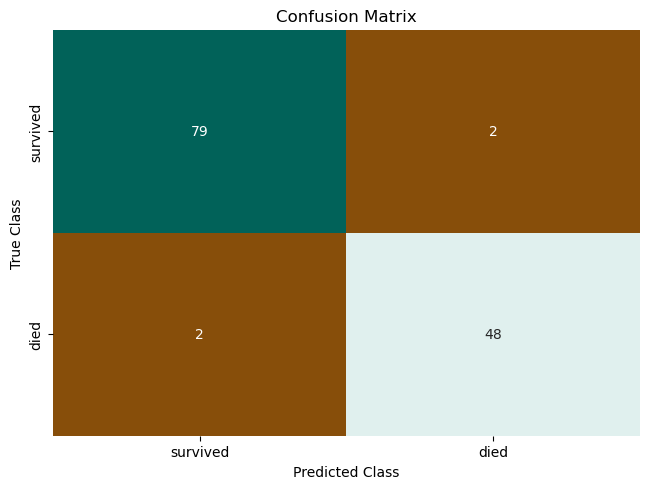

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

colormap = sns.color_palette("BrBG", 10)
sns.heatmap(df_confusion, annot=True, cbar=None, cmap=colormap)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.show()

In [21]:

from sklearn.metrics import roc_auc_score, roc_curve, auc

TN, FP, FN, TP = confusion_matrix(test_labels, target_predicted_binary).ravel()

print(f"True Negative (TN) : {TN}")
print(f"False Positive (FP): {FP}")
print(f"False Negative (FN): {FN}")
print(f"True Positive (TP) : {TP}")

True Negative (TN) : 79
False Positive (FP): 2
False Negative (FN): 2
True Positive (TP) : 48


In [24]:
# Specificity or true negative rate
Specificity  = float(TN)/(TN+FP)*100
print(f"Specificity or TNR: {Specificity}%") 
print(f"There is a {Specificity}% chance of predicting people that didnt survive survived was the correct prediction.")


Specificity or TNR: 97.53086419753086%
There is a 97.53086419753086% chance of detecting people the survived actually survived.


In [ ]:
# Precision or positive predictive value
Precision = float(TP)/(TP+FP)*100
print(f"Precision: {Precision}%")  
print(f"You didnt survive, and the probablity that is correct is {Precision}%")

In [25]:
# Fall out or false positive rate
FPR = float(FP)/(FP+TN)*100
print( f"False Positive Rate: {FPR}%") 
print( f"There is a {FPR}% chance that this positive result is incorrect.")

False Positive Rate: 2.4691358024691357%
There is a 2.4691358024691357% chance that this positive result is incorrect.


In [26]:
# False negative rate
FNR = float(FN)/(TP+FN)*100
print(f"False Negative Rate: {FNR}%") 
print(f"There is a {FNR}% chance that this negative result is incorrect.")

False Negative Rate: 4.0%
There is a 4.0% chance that this negative result is incorrect.


In [27]:
# False discovery rate
FDR = float(FP)/(TP+FP)*100
print(f"False Discovery Rate: {FDR}%" )
print(f"You have an abnormality, but there is a {FDR}% chance this is incorrect.")

False Discovery Rate: 4.0%
You have an abnormality, but there is a 4.0% chance this is incorrect.


In [28]:
# Overall accuracy
ACC = float(TP+TN)/(TP+FP+FN+TN)*100
print(f"Accuracy: {ACC}%") 

Accuracy: 96.94656488549617%


In [29]:
test_labels = test.iloc[:,0];
print("Validation AUC", roc_auc_score(test_labels, target_predicted) )

Validation AUC 0.9934567901234569


ValueError: Axis limits cannot be NaN or Inf

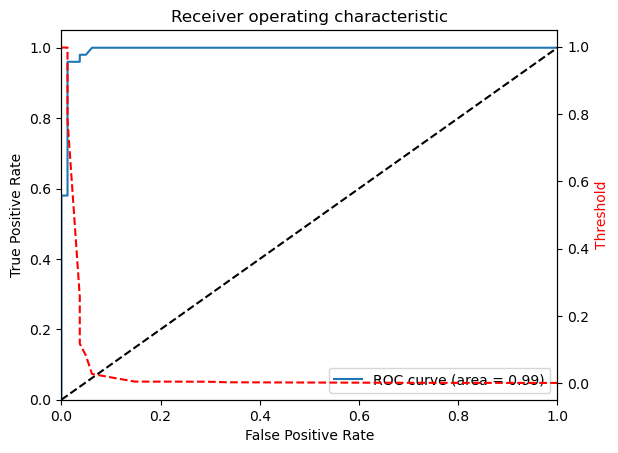

In [30]:
fpr, tpr, thresholds = roc_curve(test_labels, target_predicted)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
 
# create the axis of thresholds (scores)
ax2 = plt.gca().twinx()
ax2.plot(fpr, thresholds, markeredgecolor='r',linestyle='dashed', color='r')
ax2.set_ylabel('Threshold',color='r')
ax2.set_ylim([thresholds[-1],thresholds[0]])
ax2.set_xlim([fpr[0],fpr[-1]])

print(plt.figure())